In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.preprocessing import LabelEncoder
import sklearn
import seaborn as sns
import tensorflow as tf
from keras import regularizers
from prettytable import PrettyTable

In [ ]:
!unzip "/content/drive/MyDrive/Final Yr/NewData.zip"

Archive:  /content/drive/MyDrive/Final Yr/NewData.zip
  inflating: NewData/labelsCorrect.npy  
  inflating: NewData/videosCorrect.npy  


In [ ]:
videos = np.load('/content/NewData/videosCorrect.npy')
labels = np.load('/content/NewData/labelsCorrect.npy')

In [ ]:
# Print the shape of the videos and labels arrays
print("Videos shape:", videos.shape)
print("Labels shape:", labels.shape)

Videos shape: (2323, 22, 80, 112, 3)
Labels shape: (2323,)


In [ ]:
labels

array(['yes', 'monkey', 'the', ..., 'the', 'sunday', 'robust'],
      dtype='<U9')

In [ ]:
words = list(set(list(labels)))
words.sort()
print(words)

['a', 'beautiful', 'black', 'book', 'can', 'cat', 'chair', 'computer', 'cup', 'dog', 'drink', 'eat', 'elephant', 'excuse', 'go', 'goodbye', 'hello', 'how', 'in', 'is', 'it', 'jump', 'love', 'me', 'monkey', 'name', 'no', 'pen', 'please', 'robust', 'run', 'say', 'sleep', 'sorry', 'sunday', 'table', 'talk', 'thank', 'that', 'the', 'tiger', 'walk', 'watch', 'welcome', 'what', 'where', 'who', 'why', 'world', 'yes']


In [ ]:
label_dict = dict()
for i,j in enumerate(words):
    label_dict[i]=j
    print(label_dict[i],i)

a 0
beautiful 1
black 2
book 3
can 4
cat 5
chair 6
computer 7
cup 8
dog 9
drink 10
eat 11
elephant 12
excuse 13
go 14
goodbye 15
hello 16
how 17
in 18
is 19
it 20
jump 21
love 22
me 23
monkey 24
name 25
no 26
pen 27
please 28
robust 29
run 30
say 31
sleep 32
sorry 33
sunday 34
table 35
talk 36
thank 37
that 38
the 39
tiger 40
walk 41
watch 42
welcome 43
what 44
where 45
who 46
why 47
world 48
yes 49


In [ ]:
print(label_dict)

{0: 'a', 1: 'beautiful', 2: 'black', 3: 'book', 4: 'can', 5: 'cat', 6: 'chair', 7: 'computer', 8: 'cup', 9: 'dog', 10: 'drink', 11: 'eat', 12: 'elephant', 13: 'excuse', 14: 'go', 15: 'goodbye', 16: 'hello', 17: 'how', 18: 'in', 19: 'is', 20: 'it', 21: 'jump', 22: 'love', 23: 'me', 24: 'monkey', 25: 'name', 26: 'no', 27: 'pen', 28: 'please', 29: 'robust', 30: 'run', 31: 'say', 32: 'sleep', 33: 'sorry', 34: 'sunday', 35: 'table', 36: 'talk', 37: 'thank', 38: 'that', 39: 'the', 40: 'tiger', 41: 'walk', 42: 'watch', 43: 'welcome', 44: 'what', 45: 'where', 46: 'who', 47: 'why', 48: 'world', 49: 'yes'}


In [ ]:
encoder = LabelEncoder()
encoder.fit(labels)
encoded_labels = encoder.transform(labels)
labels = encoded_labels

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(videos, labels, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1858, 22, 80, 112, 3) (1858,)
Test set shape: (465, 22, 80, 112, 3) (465,)


In [ ]:
gc.collect()
!cat /proc/meminfo | grep Mem

MemTotal:       87532096 kB
MemFree:        33156276 kB
MemAvailable:   63548516 kB


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, BatchNormalization, Dropout, LSTM, Reshape,Bidirectional
from tensorflow.keras import regularizers

input_shape = (22, 80, 112, 3)

model = Sequential()

# Convolutional layers with Batch Normalization and Dropout
model.add(Conv3D(16, (3, 3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, (3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, (3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))
model.add(Dropout(0.25))

# Reshape to fit LSTM input requirements
model.add(Reshape((-1, 64)))

# Recurrent Layer (LSTM)
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))

# Dense layers with Dropout
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(50, activation='softmax'))


# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert the target labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train)
y_test_onehot = tf.keras.utils.to_categorical(y_test)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 20, 78, 110, 16)   1312      
                                                                 
 batch_normalization_3 (Bat  (None, 20, 78, 110, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 10, 39, 55, 16)    0         
 g3D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 10, 39, 55, 16)    0         
                                                                 
 conv3d_4 (Conv3D)           (None, 8, 37, 53, 32)     13856     
                                                                 
 batch_normalization_4 (Bat  (None, 8, 37, 53, 32)    

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

best_weights_path = 'model_weights3.h5'
# Define the ModelCheckpoint callback to save the best weights
checkpoint = ModelCheckpoint(best_weights_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Define the EarlyStopping callback to stop training if val_accuracy doesn't improve for patience number of epochs
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max', verbose=1)

In [ ]:
# Train the model and record the history of training
history = model.fit(X_train, y_train_onehot, epochs=150  ,validation_data=(X_test, y_test_onehot),callbacks=[checkpoint,early_stopping])

Epoch 1/150
59/59 [==============================] - ETA: 0s - loss: 4.2629 - accuracy: 0.0452
Epoch 1: val_accuracy improved from -inf to 0.01290, saving model to model_weights3.h5
59/59 [==============================] - 24s 194ms/step - loss: 4.2629 - accuracy: 0.0452 - val_loss: 4.5552 - val_accuracy: 0.0129
Epoch 2/150
 1/59 [..............................] - ETA: 4s - loss: 3.8663 - accuracy: 0.0938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/59 [============================>.] - ETA: 0s - loss: 3.5449 - accuracy: 0.1083
Epoch 2: val_accuracy improved from 0.01290 to 0.01720, saving model to model_weights3.h5
59/59 [==============================] - 6s 98ms/step - loss: 3.5440 - accuracy: 0.1087 - val_loss: 5.1433 - val_accuracy: 0.0172
Epoch 3/150
58/59 [============================>.] - ETA: 0s - loss: 2.9567 - accuracy: 0.2150
Epoch 3: val_accuracy improved from 0.01720 to 0.02366, saving model to model_weights3.h5
59/59 [==============================] - 6s 96ms/step - loss: 2.9575 - accuracy: 0.2147 - val_loss: 5.8372 - val_accuracy: 0.0237
Epoch 4/150
58/59 [============================>.] - ETA: 0s - loss: 2.5269 - accuracy: 0.3082
Epoch 4: val_accuracy improved from 0.02366 to 0.05376, saving model to model_weights3.h5
59/59 [==============================] - 6s 97ms/step - loss: 2.5269 - accuracy: 0.3079 - val_loss: 5.4417 - val_accuracy: 0.0538
Epoch 5/150
58/59 [============================>.] - ETA: 0s - loss

In [ ]:
model.load_weights(best_weights_path)
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

15/15 [==============================] - 2s 42ms/step


In [ ]:
report = classification_report(y_test, y_pred, output_dict=True)

table = PrettyTable()
table.field_names = ["Class", "Precision", "Recall", "F1-Score", "Support"]
for label, metrics in report.items():
    if label.isdigit():
        precision = round(metrics['precision'], 2)
        recall = round(metrics['recall'], 2)
        f1_score = round(metrics['f1-score'], 2)
        support = metrics['support']
        table.add_row([label_dict[int(label)], precision, recall, f1_score, support])

print(table)

+-----------+-----------+--------+----------+---------+
|   Class   | Precision | Recall | F1-Score | Support |
+-----------+-----------+--------+----------+---------+
|     a     |    0.92   |  1.0   |   0.96   |    12   |
| beautiful |    1.0    |  1.0   |   1.0    |    6    |
|   black   |    1.0    |  0.8   |   0.89   |    5    |
|    book   |    0.91   |  0.91  |   0.91   |    11   |
|    can    |    0.93   |  1.0   |   0.96   |    13   |
|    cat    |    0.91   |  1.0   |   0.95   |    10   |
|   chair   |    1.0    |  0.86  |   0.92   |    7    |
|  computer |    0.83   |  1.0   |   0.91   |    10   |
|    cup    |    1.0    |  1.0   |   1.0    |    12   |
|    dog    |    0.89   |  0.89  |   0.89   |    9    |
|   drink   |    1.0    |  0.92  |   0.96   |    13   |
|    eat    |    0.83   |  1.0   |   0.91   |    10   |
|  elephant |    1.0    |  0.9   |   0.95   |    10   |
|   excuse  |    1.0    |  1.0   |   1.0    |    7    |
|     go    |    1.0    |  1.0   |   1.0    |   

In [ ]:
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_pred)*100)

Balanced accuracy: 91.43727938727937


15/15 [==============================] - 1s 41ms/step


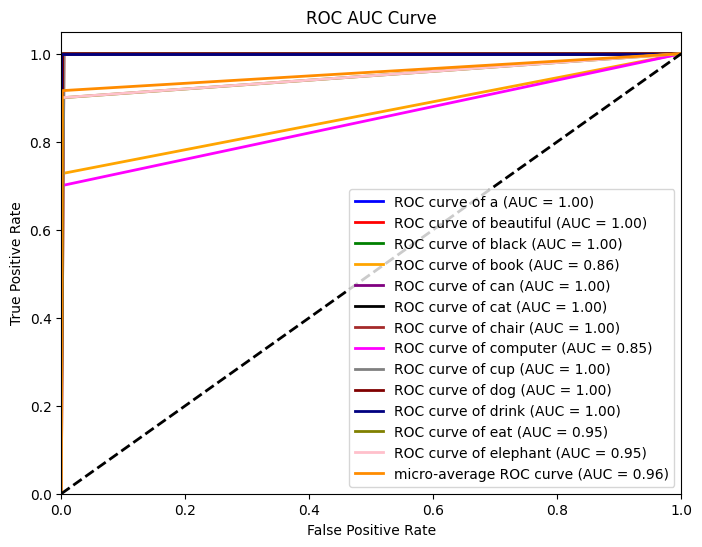

In [ ]:
# Convert y_true and y_pred to one-hot encoding
n_classes = len(np.unique(y_test))
y_true_bin = label_binarize(y_test, classes=np.arange(n_classes))
y_pred_bin = model.predict(X_test)
y_pred_bin = label_binarize(np.argmax(y_pred_bin, axis=1), classes=np.arange(n_classes))

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC AUC
fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_bin.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curves
plt.figure(figsize=(8,6))
lw = 2
colors = ['blue', 'red', 'green', 'orange', 'purple', 'black', 'brown', 'magenta', 'gray', 'maroon', 'navy', 'olive', 'pink']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (AUC = {1:0.2f})'
             ''.format(label_dict[i], roc_auc[i]))
plt.plot(fpr_micro, tpr_micro, color='darkorange', lw=lw,
         label='micro-average ROC curve (AUC = {0:0.2f})'
         ''.format(roc_auc_micro))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc="lower right")
plt.show()

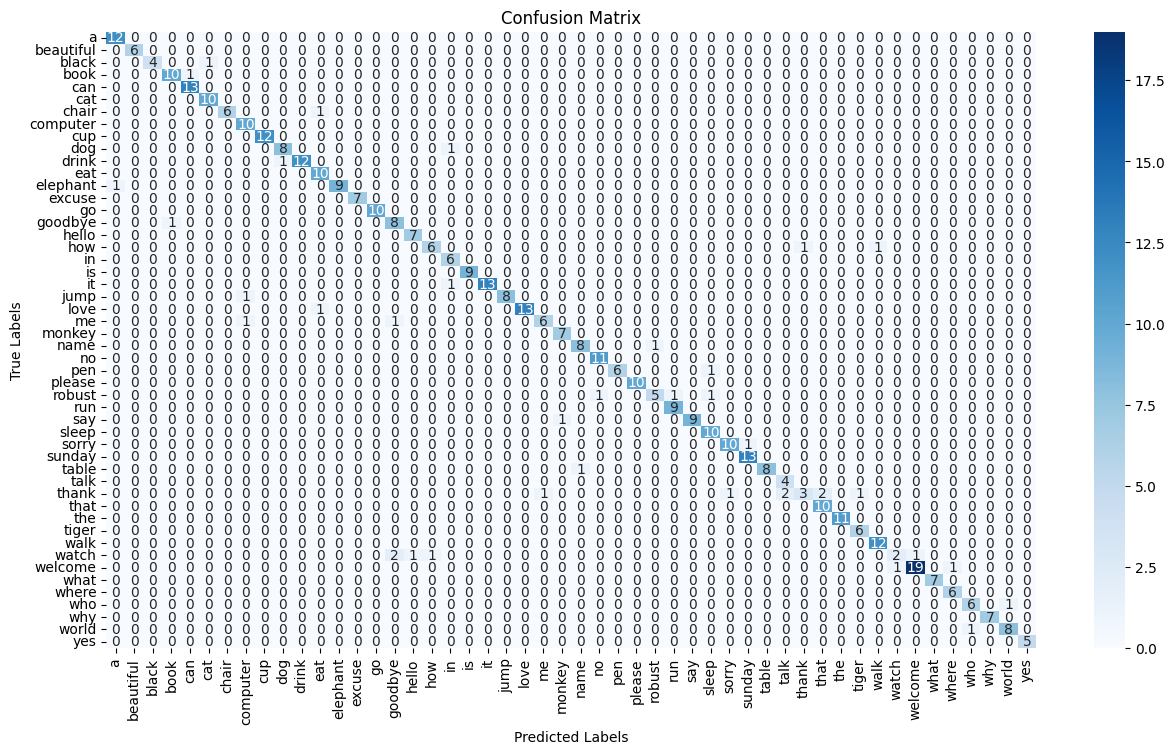

In [ ]:
conf_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)

# Define the list of label strings in the order of their integer values
label_strings = [label_dict[i] for i in range(len(label_dict))]

# Generate the heatmap confusion matrix
plt.figure(figsize=(15,8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", xticklabels=label_strings, yticklabels=label_strings)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()